In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

In [2]:
df = pd.read_csv('Copy of transactions1.csv', sep=';')
df.head()

C:\Users\Edwardus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,transaction_id,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,5533441,733493772,733493772,5000,5000.0,2016-01-08T19:04:50,111.33,Lyft,US,US,...,True,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False
1,5533442,733493772,733493772,5000,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,...,False,NaN,111.33,NaN,NaN,NaN,False,NaN,NaN,False
2,5533443,733493772,733493772,5000,4863.92,2016-01-11T13:36:55,187.4,Lyft,US,US,...,False,NaN,136.08,NaN,NaN,NaN,False,NaN,NaN,False
3,5533444,733493772,733493772,5000,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,...,True,NaN,323.48,NaN,NaN,NaN,False,NaN,NaN,False
4,5533445,733493772,733493772,5000,4449.18,2016-01-16T01:41:11,0.0,Lyft,US,US,...,False,NaN,550.82,NaN,NaN,NaN,False,NaN,NaN,False


In [3]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [5]:
def preprocess(df):

    #transfrom datetime column
    df['transactionDateTime'] = df['transactionDateTime'].str.replace('T', ' ')
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='%d/%m/%Y', errors='coerce')
    df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'], format='%d/%m/%Y', errors='coerce')
    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'], format='%d/%m/%Y', errors='coerce')

    df = df.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis=1)
    
    df['merchantCountryCode'] = df['merchantCountryCode'].fillna('unspecified')
    df['acqCountry'] = df['acqCountry'].fillna('unspecified')
    
    #change to numeric, error will be NaN
    df['availableMoney'] = pd.to_numeric(df['availableMoney'], errors='coerce')
    df['transactionAmount'] = pd.to_numeric(df['transactionAmount'], errors='coerce')
    df['currentBalance'] = pd.to_numeric(df['currentBalance'], errors='coerce')
    
    df.loc[df['availableMoney'].isnull(), 'availableMoney'] = df.loc[df['availableMoney'].isnull(), 'creditLimit'] - df.loc[df['availableMoney'].isnull(), 'currentBalance']
    df.loc[df['currentBalance'].isnull(), 'currentBalance'] = df.loc[df['availableMoney'].isnull(), 'creditLimit'] - df.loc[df['availableMoney'].isnull(), 'availableMoney']
    
    df['transaction_hour'] = df['transactionDateTime'].dt.hour
    df['transaction_day'] = df['transactionDateTime'].dt.day
    df['transaction_month'] = df['transactionDateTime'].dt.month
    
    df['address_day'] = df['dateOfLastAddressChange'].dt.day
    df['address_month'] = df['dateOfLastAddressChange'].dt.month
    
    df['open_address_days'] = (df['dateOfLastAddressChange'] - df['accountOpenDate'])
    df['open_address_days'] = pd.to_numeric(df['open_address_days'], errors='coerce')
    
    df['cardPresent_posEntryMode'] = df['cardPresent'] * df['posEntryMode']
    df['cardPresent_posConditionCode'] = df['cardPresent'] * df['posConditionCode']
    df['merchantCategoryCode_posEntryMode'] = df['merchantCategoryCode'] + '_' + str(df['posEntryMode'])
    df['merchantCategoryCode_posConditionCode'] = df['merchantCategoryCode'] + '_' + str(df['posConditionCode'])
    
    return df

In [7]:
X_train = preprocess(X_train)
X_train.head()

C:\Users\Edwardus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Edwardus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Edwardus\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,transaction_id,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,transaction_hour,transaction_day,transaction_month,address_day,address_month,open_address_days,cardPresent_posEntryMode,cardPresent_posConditionCode,merchantCategoryCode_posEntryMode,merchantCategoryCode_posConditionCode
602050,6135491,770755172,770755172,20000,5903.86,2016-11-10 16:04:13,36.18,walmart.com,US,US,...,16,10,11,2,2,0,0.0,0.0,online_retail_602050 5.0\n124673 9.0\n60...,online_retail_602050 1.0\n124673 1.0\n60...
124673,5658114,596998124,596998124,15000,12219.69,2016-05-08 06:02:26,3.22,South Steakhouse #879581,US,US,...,6,8,5,15,7,0,9.0,1.0,food_602050 5.0\n124673 9.0\n605469 5...,food_602050 1.0\n124673 1.0\n605469 1...
605469,6138910,946281748,946281748,500,436.93,2016-01-16 02:58:12,23.30,Universe Massage #114220,US,US,...,2,16,1,17,4,0,5.0,1.0,personal care_602050 5.0\n124673 9.0\n60...,personal care_602050 1.0\n124673 1.0\n60...
47726,5581167,419565181,419565181,2500,582.99,2016-06-17 10:33:05,59.44,MyApron,US,US,...,10,17,6,10,10,0,0.0,0.0,food_delivery_602050 5.0\n124673 9.0\n60...,food_delivery_602050 1.0\n124673 1.0\n60...
45224,5578665,588397240,588397240,500,449.35,2016-01-27 18:14:11,50.65,Lyft,US,US,...,18,27,1,16,2,0,0.0,0.0,rideshare_602050 5.0\n124673 9.0\n605469...,rideshare_602050 1.0\n124673 1.0\n605469...


In [8]:
X_test = preprocess(X_test)
X_test.head()

C:\Users\Edwardus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Edwardus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Edwardus\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,transaction_id,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,transaction_hour,transaction_day,transaction_month,address_day,address_month,open_address_days,cardPresent_posEntryMode,cardPresent_posConditionCode,merchantCategoryCode_posEntryMode,merchantCategoryCode_posConditionCode
477945,6011386,871701939,871701939,15000,11552.59,2016-07-23 00:20:32,420.67,Mobile eCards,US,US,...,0,23,7,7,1,0,0.0,0.0,online_gifts_477945 9.0\n531502 9.0\n139...,online_gifts_477945 1.0\n531502 1.0\n139...
531502,6064943,318001076,318001076,50000,12918.72,2016-03-12 08:26:30,1.46,Burger King #446273,US,US,...,8,12,3,7,3,7516800000000000,9.0,1.0,fastfood_477945 9.0\n531502 9.0\n139612 ...,fastfood_477945 1.0\n531502 1.0\n139612 ...
139612,5673053,803896888,803896888,15000,10991.56,2016-07-28 03:08:49,527.03,Fresh Flowers,US,US,...,3,28,7,18,12,0,0.0,0.0,online_gifts_477945 9.0\n531502 9.0\n139...,online_gifts_477945 1.0\n531502 1.0\n139...
342805,5876246,322865480,322865480,15000,15000.00,2016-01-06 22:05:31,17.54,Arbys #599566,US,US,...,22,6,1,18,7,0,2.0,1.0,fastfood_477945 9.0\n531502 9.0\n139612 ...,fastfood_477945 1.0\n531502 1.0\n139612 ...
275697,5809138,892489502,892489502,15000,15000.00,2016-12-13 22:40:51,3.93,Apple iTunes,US,US,...,22,13,12,2,10,0,0.0,0.0,mobileapps_477945 9.0\n531502 9.0\n13961...,mobileapps_477945 1.0\n531502 1.0\n13961...


# Preprocess Pipeline

In [9]:
CB_encoder = ce.CatBoostEncoder(cols=['merchantName',
                                      'acqCountry',
                                      'merchantCountryCode',
                                      'merchantCategoryCode',
                                      'transactionType',
                                      'posEntryMode',
                                      'posConditionCode',
                                      'cardPresent_posEntryMode',
                                      'cardPresent_posConditionCode',
                                      'merchantCategoryCode_posEntryMode',
                                      'merchantCategoryCode_posConditionCode'])

CB_encoder.fit(X_train[['merchantName',
                        'acqCountry',
                        'merchantCountryCode',
                        'merchantCategoryCode',
                        'transactionType',
                        'posEntryMode',
                        'posConditionCode',
                        'cardPresent_posEntryMode',
                        'cardPresent_posConditionCode',
                        'merchantCategoryCode_posEntryMode',
                        'merchantCategoryCode_posConditionCode']], y_train)

X_train = X_train.join(CB_encoder.transform(X_train[['merchantName',
                                                    'acqCountry',
                                                    'merchantCountryCode',
                                                    'merchantCategoryCode',
                                                    'transactionType',
                                                    'posEntryMode',
                                                    'posConditionCode',
                                                    'cardPresent_posEntryMode',
                                                    'cardPresent_posConditionCode',
                                                    'merchantCategoryCode_posEntryMode',
                                                    'merchantCategoryCode_posConditionCode']]).add_suffix('_cb'))

In [10]:
X_train = X_train.drop(['merchantName', 'acqCountry', 'merchantCountryCode',
                        'merchantCategoryCode', 'transactionType', 'posEntryMode',
                        'posConditionCode', 'customerId', 'expirationDateKeyInMatch',
                        'acqCountry_cb', 'cardCVV', 'enteredCVV'], axis=1)

In [11]:
object_cols = X_train.select_dtypes('object').columns
X_train = X_train.drop(object_cols, axis=1)

In [12]:
date_cols = X_train.select_dtypes('datetime64').columns
X_train = X_train.drop(date_cols, axis=1)

In [13]:
X_train['v1'] = X_train['transactionAmount'] * X_train['merchantName_cb']
X_train['v2'] = X_train['transactionAmount'] * X_train['merchantCategoryCode_cb']

In [14]:
column_names = X_train.columns
column_names

Index(['transaction_id', 'accountNumber', 'creditLimit', 'availableMoney',
       'transactionAmount', 'cardLast4Digits', 'currentBalance', 'cardPresent',
       'transaction_hour', 'transaction_day', 'transaction_month',
       'address_day', 'address_month', 'open_address_days',
       'cardPresent_posEntryMode', 'cardPresent_posConditionCode',
       'merchantName_cb', 'merchantCountryCode_cb', 'merchantCategoryCode_cb',
       'transactionType_cb', 'posEntryMode_cb', 'posConditionCode_cb',
       'cardPresent_posEntryMode_cb', 'cardPresent_posConditionCode_cb',
       'merchantCategoryCode_posEntryMode_cb',
       'merchantCategoryCode_posConditionCode_cb', 'v1', 'v2'],
      dtype='object')

In [15]:
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

SimpleImputer(strategy='median')

In [16]:
X_train = imputer.transform(X_train)

In [17]:
#scaler = MinMaxScaler(feature_range = (0, 1))

#scaler.fit(X_train)

In [18]:
#X_train = scaler.transform(X_train)

In [19]:
df_train = pd.DataFrame(X_train.copy(), y_train)

In [20]:
df_train.columns = column_names

df_train = df_train.reset_index()
df_train

,isFraud,transaction_id,accountNumber,creditLimit,availableMoney,transactionAmount,cardLast4Digits,currentBalance,cardPresent,transaction_hour,...,merchantCategoryCode_cb,transactionType_cb,posEntryMode_cb,posConditionCode_cb,cardPresent_posEntryMode_cb,cardPresent_posConditionCode_cb,merchantCategoryCode_posEntryMode_cb,merchantCategoryCode_posConditionCode_cb,v1,v2
0,False,6135491.0,770755172.0,20000.0,5903.86,36.18,8420.0,14096.14,0.0,16.0,...,0.022501,0.017808,0.007911,0.018012,0.018931,0.019286,0.022501,0.022501,0.542119,0.814082
1,False,5658114.0,596998124.0,15000.0,12219.69,3.22,1503.0,2780.31,1.0,6.0,...,0.020257,0.017808,0.028086,0.018012,0.023541,0.015802,0.020257,0.020257,0.014372,0.065228
2,False,6138910.0,946281748.0,500.0,436.93,23.30,40.0,63.07,1.0,2.0,...,0.012524,0.017808,0.007911,0.018012,0.008303,0.015802,0.012524,0.012524,0.162376,0.291807
3,False,5581167.0,419565181.0,2500.0,582.99,59.44,905.0,1917.01,0.0,10.0,...,0.000006,0.017808,0.007911,0.013865,0.018931,0.019286,0.000006,0.000006,0.001600,0.000347
4,False,5578665.0,588397240.0,500.0,449.35,50.65,8354.0,50.65,0.0,18.0,...,0.021974,0.017734,0.007911,0.013865,0.018931,0.019286,0.021974,0.021974,1.047966,1.112978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385143,False,5643709.0,353215513.0,7500.0,2170.52,141.13,2705.0,5329.48,1.0,21.0,...,0.020257,0.017808,0.028086,0.018012,0.023541,0.015802,0.020257,0.020257,1.143115,2.858902
385144,False,5792619.0,281253442.0,5000.0,4202.84,225.56,891.0,797.16,0.0,0.0,...,0.022501,0.017808,0.007911,0.018012,0.018931,0.019286,0.022501,0.022501,6.818838,5.075298
385145,False,5899279.0,741555408.0,50000.0,50000.00,24.68,9127.0,0.00,1.0,11.0,...,0.027625,0.017808,0.007911,0.018012,0.008303,0.015802,0.027625,0.027625,0.374792,0.681789
385146,False,5665373.0,334019691.0,15000.0,13685.28,49.04,4465.0,1314.72,1.0,8.0,...,0.000001,0.017808,0.018549,0.018012,0.016091,0.015802,0.000001,0.000001,0.007648,0.000063


Text(0.5, 1, 'Variables Correlation Heatmap')

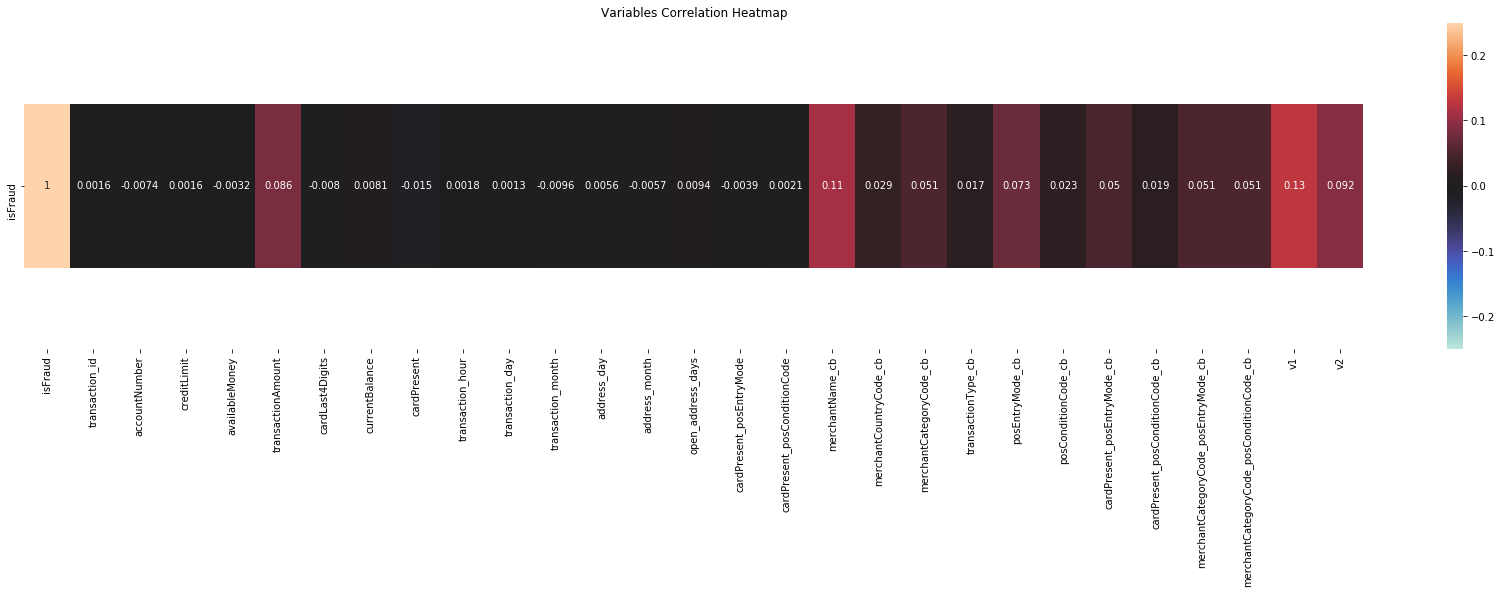

In [21]:
corr = df_train.corr()
corr2 = corr.loc[:'isFraud',:]

plt.figure(figsize=(30,6))
ax = sns.heatmap(corr2, annot=True, vmin=-0.25, vmax=0.25, center=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Variables Correlation Heatmap')

In [22]:
from collections import Counter
from imblearn.over_sampling import SVMSMOTE
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y_train)
print(counter)
# define the undersampling method
undersample = SVMSMOTE(sampling_strategy=0.18, random_state=42, n_jobs=4)
# transform the dataset
X_train_sampled, y_train_sampled = undersample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train_sampled)
print(counter)

Counter({False: 378421, True: 6727})
Counter({False: 378421, True: 68115})


In [24]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y_train_sampled)
print(counter)
# define the undersampling method
undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
# transform the dataset
X_train_sampled, y_train_sampled = undersample.fit_resample(X_train_sampled, y_train_sampled)
# summarize the new class distribution
counter = Counter(y_train_sampled)
print(counter)

Counter({False: 378421, True: 68115})
Counter({False: 97307, True: 68115})


In [25]:
transactionAmount_test = X_test['transactionAmount']

In [26]:
X_test = X_test.join(CB_encoder.transform(X_test[['merchantName',
                                                    'acqCountry',
                                                    'merchantCountryCode',
                                                    'merchantCategoryCode',
                                                    'transactionType',
                                                    'posEntryMode',
                                                    'posConditionCode',
                                                    'cardPresent_posEntryMode',
                                                    'cardPresent_posConditionCode',
                                                    'merchantCategoryCode_posEntryMode',
                                                    'merchantCategoryCode_posConditionCode']]).add_suffix('_cb'))

X_test = X_test.drop(['merchantName', 'acqCountry', 'merchantCountryCode',
                        'merchantCategoryCode', 'transactionType', 'posEntryMode',
                        'posConditionCode', 'customerId', 'expirationDateKeyInMatch',
                        'acqCountry_cb', 'cardCVV', 'enteredCVV'], axis=1)

X_test = X_test.drop(object_cols, axis=1)
X_test = X_test.drop(date_cols, axis=1)

X_test['v1'] = X_test['transactionAmount'] * X_test['merchantName_cb']
X_test['v2'] = X_test['transactionAmount'] * X_test['merchantCategoryCode_cb']

X_test = imputer.transform(X_test)
#X_test = scaler.transform(X_test)

In [27]:
rf = RandomForestClassifier(n_jobs=4, random_state=42)
rf.fit(X_train_sampled, y_train_sampled)

RandomForestClassifier(n_jobs=4, random_state=42)

In [28]:
y_pred_rf = rf.predict(X_test)

confusion_matrix(y_test, y_pred_rf)

array([[246127,   6064],
       [  3791,    784]], dtype=int64)

In [29]:
print(classification_report(y_test, y_pred_rf))
print('ROC-AUC score :  ', roc_auc_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98    252191
        True       0.11      0.17      0.14      4575

    accuracy                           0.96    256766
   macro avg       0.55      0.57      0.56    256766
weighted avg       0.97      0.96      0.97    256766

ROC-AUC score :   0.5736604264705


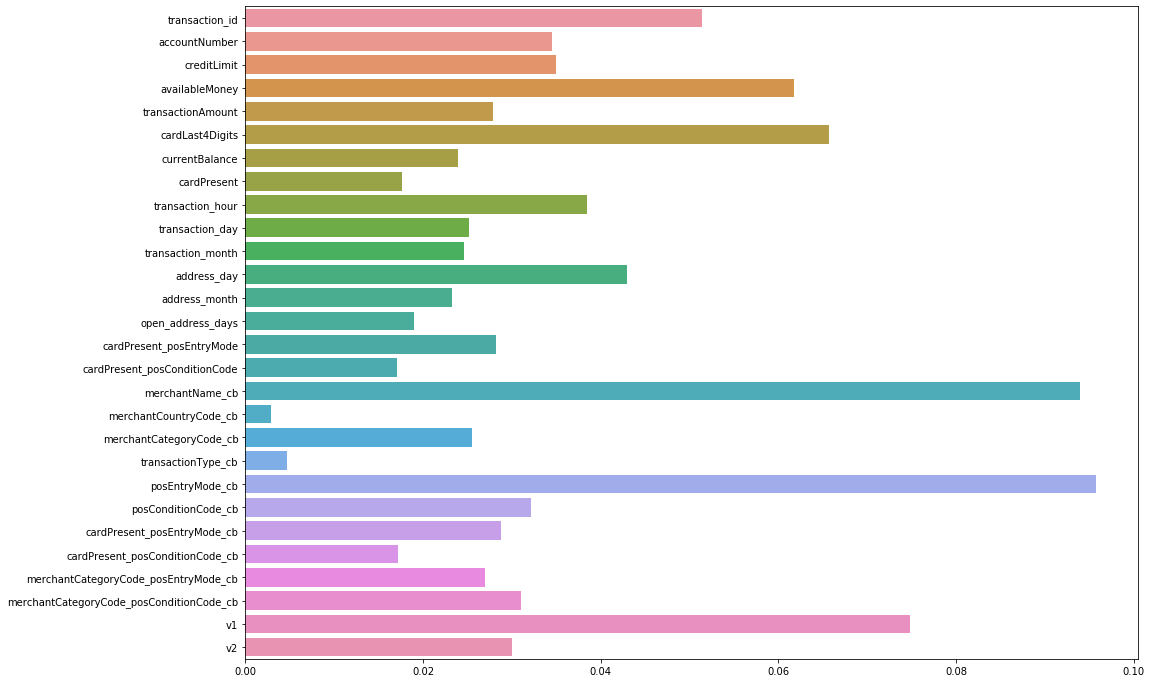

In [30]:
plt.figure(figsize=(16,12))
sns.barplot(y=column_names, x=rf.feature_importances_)

In [31]:
xgb2 = XGBClassifier(n_jobs=4, random_state=42)
xgb2.fit(X_train_sampled, y_train_sampled)
y_pred_xgb2 = xgb2.predict(X_test)

confusion_matrix(y_test, y_pred_xgb2)

array([[250761,   1430],
       [  4066,    509]], dtype=int64)

In [32]:
print(classification_report(y_test, y_pred_xgb2))
print('ROC-AUC score :  ', roc_auc_score(y_test, y_pred_xgb2))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99    252191
        True       0.26      0.11      0.16      4575

    accuracy                           0.98    256766
   macro avg       0.62      0.55      0.57    256766
weighted avg       0.97      0.98      0.97    256766

ROC-AUC score :   0.5527932625789981


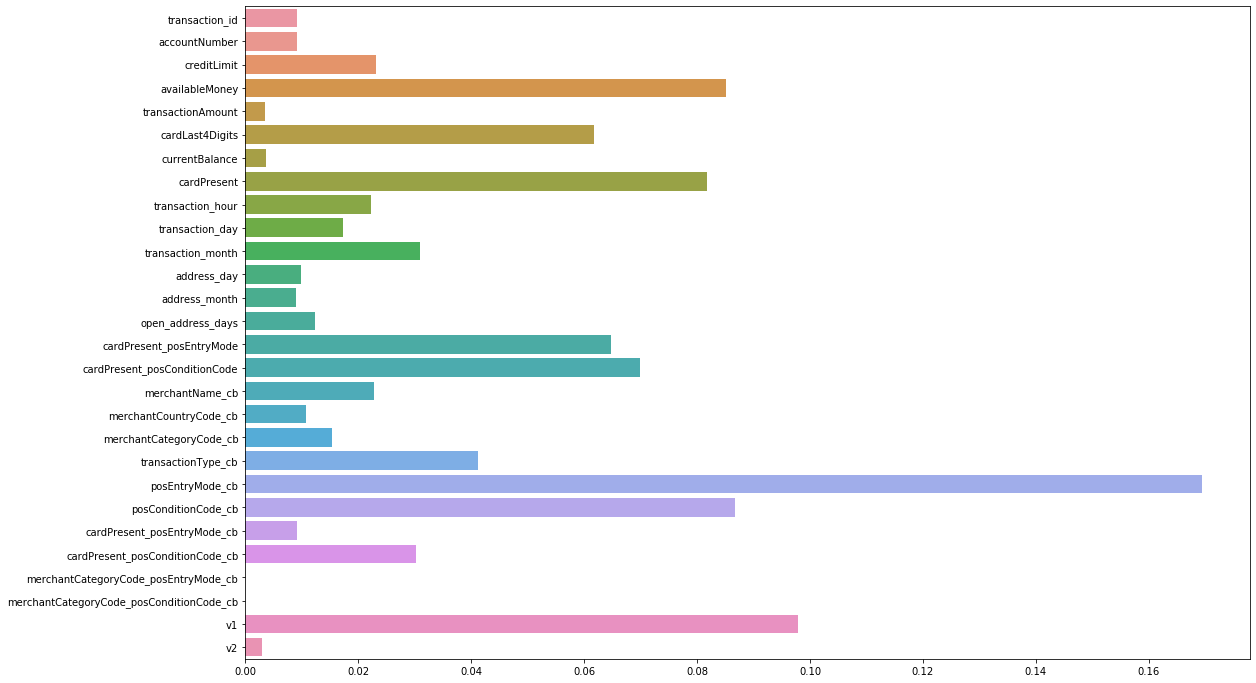

In [33]:
plt.figure(figsize=(18,12))
sns.barplot(y=column_names, x=xgb2.feature_importances_)

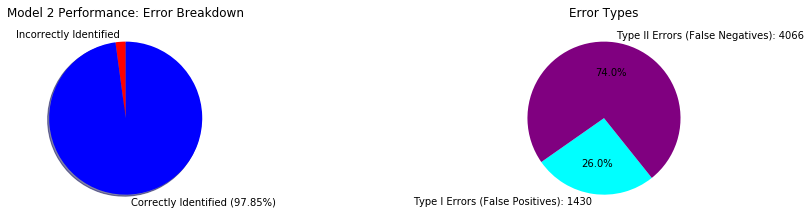

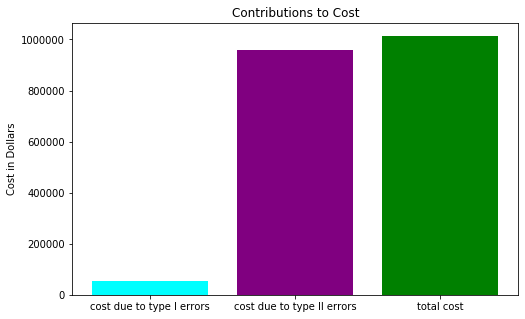

The total cost of this model on our test set is: $1013880


In [49]:
#record results:
results2 = pd.DataFrame()
results2['true_value'] = np.array(y_test) # y test
results2['predicted'] = y_pred_xgb2# y pred
results2['correct'] = np.where(results2.predicted == results2.true_value, 1, 0)
results2['tI_error'] = np.where((results2.predicted == 1) & (results2.true_value == 0), 1, 0)
results2['tII_error'] = np.where((results2.predicted == 0) & (results2.true_value == 1), 1, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Model 2 Performance: Error Breakdown')
lbl = ['Incorrectly Identified', 
       'Correctly Identified ({}%)'.format(str(100*results2.correct.sum()/len(results2))[:5])
]
sz = [results2.tII_error.sum() + results2.tI_error.sum(), results2.correct.sum()]
clrs = ['red', 'blue']
ax1.pie(sz, labels=lbl, colors=clrs, shadow=True, startangle=90)

ax2.set_title('Error Types')
labels = [
    'Type I Errors (False Positives): {}'.format(results2.tI_error.sum()),
    'Type II Errors (False Negatives): {}'.format(results2.tII_error.sum())
]
sizes = [
    results2.tI_error.sum(),
    results2.tII_error.sum()
]

ax2.pie(sizes, labels=labels, colors=['cyan', 'purple'], startangle=215, 
        autopct='%1.1f%%')
plt.subplots_adjust(wspace=1.5)
plt.show()

results2['Amount'] = np.array(transactionAmount_test) # column amount in X test
#type I error cost, as defined
results2['cost_I'] = np.where(results2.tI_error == 1, (25 + 10 + (.01*results2.Amount)), 0)
#type II error cost, as defined
results2['cost_II'] = np.where(results2.tII_error == 1, results2.Amount, 0)
results2['total_cost'] = results2[['cost_I', 'cost_II']].sum(axis=1)
total_cost_I = results2.cost_I.sum()
total_cost_II = results2.cost_II.sum()
total_cost = total_cost_I + total_cost_II

fig, ax = plt.subplots(figsize=(8, 5))
plt.bar(
    ['cost due to type I errors', 'cost due to type II errors', 'total cost'], 
    [total_cost_I, total_cost_II, total_cost],
    color=['cyan', 'purple', 'green']
);
plt.title('Contributions to Cost');
plt.ylabel('Cost in Dollars');
plt.show();

print("The total cost of this model on our test set is: ${}".format(str(total_cost)[:7]))
total_cost_pred = total_cost

In [46]:
results2[(results2['true_value']==False)&(results2['predicted']==True)]['Amount'].sum()

915726.66

# Hyperparameter Optimization

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Declare xgboost search space for Hyperopt
xgboost_space={
            'max_depth': hp.choice('x_max_depth',[2,3,4,5,6]),
            'min_child_weight':hp.choice('x_min_child_weight',np.round(np.arange(0.0,0.2,0.01),5)),
            'learning_rate':hp.choice('x_learning_rate',np.round(np.arange(0.005,0.3,0.01),5)),
            'subsample':hp.choice('x_subsample',np.round(np.arange(0.1,1.0,0.05),5)),
            'colsample_bylevel':hp.choice('x_colsample_bylevel',np.round(np.arange(0.1,1.0,0.05),5)),
            'colsample_bytree':hp.choice('x_colsample_bytree',np.round(np.arange(0.1,1.0,0.05),5)),
            'n_estimators':hp.choice('x_n_estimators',np.arange(25,100,5)),
            'gamma' : hp.quniform('gamma', 0, 0.50, 0.01)
            }

best_score = 1.0

def objective(space):
    
    global best_score
    model = XGBClassifier(**space, n_jobs=-1)   
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    score = -cross_val_score(model, X_train_sampled, y_train_sampled, cv=kfold, scoring='precision_micro', verbose=False, n_jobs=-1).mean()
    
    if (score < best_score):
        best_score = score
    
    return score

best = fmin(
  objective, 
  space = xgboost_space, 
  algo = tpe.suggest, 
  max_evals = 35,
  trials = Trials())

print("Best score: %.2f " % (-best_score))
print("Best space: ", best) 

100%|██████████| 35/35 [19:08<00:00, 32.81s/trial, best loss: -0.959787699463652] 
Best score: 0.96 
Best space:  {'gamma': 0.15, 'x_colsample_bylevel': 17, 'x_colsample_bytree': 14, 'x_learning_rate': 27, 'x_max_depth': 4, 'x_min_child_weight': 6, 'x_n_estimators': 13, 'x_subsample': 11}


In [38]:
from xgboost import XGBClassifier
xgb_opt = XGBClassifier(n_estimators = np.arange(25,100,5)[best['x_n_estimators']],
                            max_depth = [2,3,4,5,6][best['x_max_depth']],
                            learning_rate = np.round(np.arange(0.005,0.3,0.01),5)[best['x_learning_rate']],
                            colsample_bylevel = np.round(np.arange(0.1,1.0,0.05),5)[best['x_colsample_bylevel']],
                            min_child_weight = np.round(np.arange(0.0,0.2,0.01),5)[best['x_min_child_weight']],
                            subsample = np.round(np.arange(0.1,1.0,0.05),5)[best['x_subsample']],
                            colsample_bytree = np.round(np.arange(0.1,1.0,0.05),5)[best['x_colsample_bytree']],
                        gamma = best['gamma']
                            )

xgb_opt.fit(X_train_sampled, y_train_sampled)
y_pred_xgb_opt = xgb_opt.predict(X_test)

confusion_matrix(y_test, y_pred_xgb_opt)

array([[249415,   2776],
       [  3974,    601]], dtype=int64)

In [39]:
print(classification_report(y_test, y_pred_xgb_opt))
print('ROC-AUC score :  ', roc_auc_score(y_test, y_pred_xgb_opt))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99    252191
        True       0.18      0.13      0.15      4575

    accuracy                           0.97    256766
   macro avg       0.58      0.56      0.57    256766
weighted avg       0.97      0.97      0.97    256766

ROC-AUC score :   0.5601792951057804


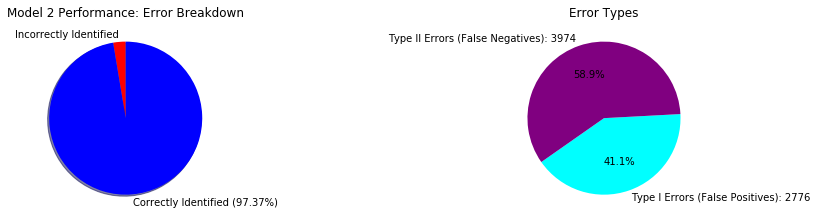

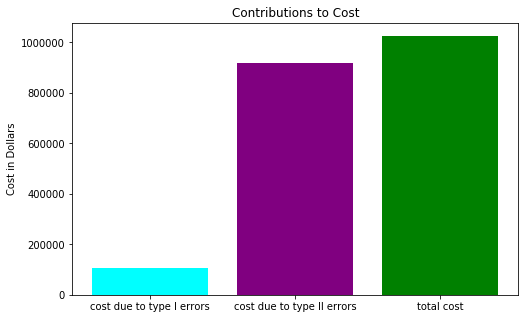

The total cost of this model on our test set is: $1025731


In [40]:
#record results:
results2 = pd.DataFrame()
results2['true_value'] = np.array(y_test) # y test
results2['predicted'] = y_pred_xgb_opt# y pred
results2['correct'] = np.where(results2.predicted == results2.true_value, 1, 0)
results2['tI_error'] = np.where((results2.predicted == 1) & (results2.true_value == 0), 1, 0)
results2['tII_error'] = np.where((results2.predicted == 0) & (results2.true_value == 1), 1, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Model 2 Performance: Error Breakdown')
lbl = ['Incorrectly Identified', 
       'Correctly Identified ({}%)'.format(str(100*results2.correct.sum()/len(results2))[:5])
]
sz = [results2.tII_error.sum() + results2.tI_error.sum(), results2.correct.sum()]
clrs = ['red', 'blue']
ax1.pie(sz, labels=lbl, colors=clrs, shadow=True, startangle=90)

ax2.set_title('Error Types')
labels = [
    'Type I Errors (False Positives): {}'.format(results2.tI_error.sum()),
    'Type II Errors (False Negatives): {}'.format(results2.tII_error.sum())
]
sizes = [
    results2.tI_error.sum(),
    results2.tII_error.sum()
]

ax2.pie(sizes, labels=labels, colors=['cyan', 'purple'], startangle=215, 
        autopct='%1.1f%%')
plt.subplots_adjust(wspace=1.5)
plt.show()

results2['Amount'] = np.array(transactionAmount_test) # column amount in X test
#type I error cost, as defined
results2['cost_I'] = np.where(results2.tI_error == 1, (25 + 10 + (.01*results2.Amount)), 0)
#type II error cost, as defined
results2['cost_II'] = np.where(results2.tII_error == 1, results2.Amount, 0)
results2['total_cost'] = results2[['cost_I', 'cost_II']].sum(axis=1)
total_cost_I = results2.cost_I.sum()
total_cost_II = results2.cost_II.sum()
total_cost = total_cost_I + total_cost_II

fig, ax = plt.subplots(figsize=(8, 5))
plt.bar(
    ['cost due to type I errors', 'cost due to type II errors', 'total cost'], 
    [total_cost_I, total_cost_II, total_cost],
    color=['cyan', 'purple', 'green']
);
plt.title('Contributions to Cost');
plt.ylabel('Cost in Dollars');
plt.show();

print("The total cost of this model on our test set is: ${}".format(str(total_cost)[:7]))
total_cost_pred = total_cost

# PCA

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca.fit(X_train_sampled)

PCA(n_components=12)

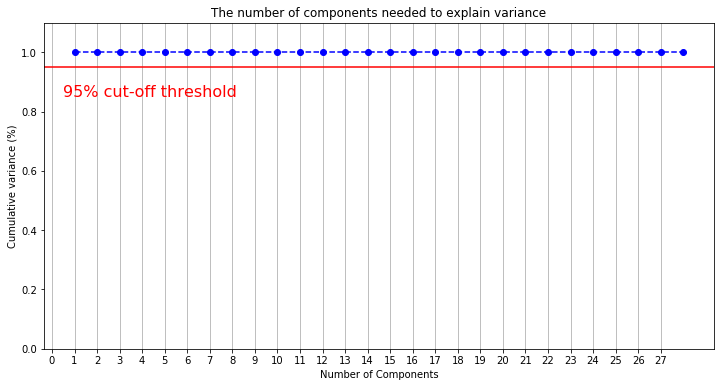

In [54]:
pca = PCA().fit(X_train_sampled)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 29, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 28, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [45]:
X_train_pca = pca.transform(X_train_sampled)
X_test_pca = pca.transform(X_test)

In [46]:
rf.fit(X_train_pca, y_train_sampled)
y_pred_rf = rf.predict(X_test_pca)
confusion_matrix(y_test, y_pred_rf)

array([[234864,  17327],
       [  3586,    989]], dtype=int64)

In [47]:
print(classification_report(y_test, y_pred_rf))
print('ROC-AUC score :  ', roc_auc_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       0.98      0.93      0.96    252191
        True       0.05      0.22      0.09      4575

    accuracy                           0.92    256766
   macro avg       0.52      0.57      0.52    256766
weighted avg       0.97      0.92      0.94    256766

ROC-AUC score :   0.5737345007805147


In [48]:
xgb2 = XGBClassifier(n_jobs=4)
xgb2.fit(X_train_pca, y_train_sampled)
y_pred_xgb2 = xgb2.predict(X_test_pca)

confusion_matrix(y_test, y_pred_xgb2)

array([[220744,  31447],
       [  3062,   1513]], dtype=int64)

In [49]:
print(classification_report(y_test, y_pred_xgb2))
print('ROC-AUC score :  ', roc_auc_score(y_test, y_pred_xgb2))

              precision    recall  f1-score   support

       False       0.99      0.88      0.93    252191
        True       0.05      0.33      0.08      4575

    accuracy                           0.87    256766
   macro avg       0.52      0.60      0.50    256766
weighted avg       0.97      0.87      0.91    256766

ROC-AUC score :   0.6030076054984174
